In [3]:
import math
from numpy import linalg
import numpy as np
from matplotlib import pyplot as plt 

def fermi_by_pade(omega):
    result = 0.5
    for j in range(num_pade):
        result = result + tilde_eta[j] / (omega / T + pole[j]) \
                        + tilde_eta[j] / (omega / T - pole[j])
    return result

def convert(o):
    if isinstance(o, np.int64): return int(o)
    raise TypeError


def fFeim(x, pole, resi, sigma=1):
    return 1 / 2 - sigma * sum(2.0 * resi[i] * x / (x**2 + pole[i]**2)
                               for i in range(len(pole)))


def tseig(D, E):
    mat = np.diag(E, -1) + np.diag(D, 0) + np.diag(E, 1)
    return -np.sort(-np.linalg.eigvalsh(mat))


def MSD(N, BoseFermi=2):
    if BoseFermi == 1:
        pole = np.array([2 * (i + 1) * np.pi for i in range(N)])
        resi = np.ones(N, dtype=float)
        return pole, resi
    elif BoseFermi == 2:
        pole = np.array([(2 * i + 1) * np.pi for i in range(N)])
        resi = np.ones(N, dtype=float)
        return pole, resi


def PSD(N, BoseFermi=2, pade=0):
    if N < 0 or BoseFermi < 1 or BoseFermi > 2 or pade < 0 or pade > 3:
        raise ValueError("N or BoseFermi or pade has wrong value!")

    if pade == 0:
        return MSD(N, BoseFermi)
    elif pade == 1 or pade == 2:
        pole, resi = [], []
        if N > 0:
            M = 2 * N + pade // 2
            temp = 3.0 if BoseFermi == 1 else 1.0
            diag = np.zeros(M, dtype=float)
            doff = np.array([
                1.0 / math.sqrt((temp + 2.0 * i) * (temp + 2.0 * (i + 1)))
                for i in range(M - 1)
            ])
            pole = 2.0 / tseig(diag, doff)[:N]
            pol2 = np.array([x * x for x in pole])
            M -= 1
            temp = 5.0 if BoseFermi == 1 else 3.0
            diag = np.zeros(M, dtype=float)
            doff = np.array([
                1.0 / math.sqrt((temp + 2.0 * i) * (temp + 2.0 * (i + 1)))
                for i in range(M - 1)
            ])
            M //= 2
            eig2 = np.power(2.0 / tseig(diag, doff)[:M], 2)
            print(eig2)

            scaling = 0.0
            if BoseFermi == 1:
                scaling = N*(2.0*N+3.0) if pade == 1 else 1.0 / \
                    (4.0*(N+1.0)*(2.0*N+3.0))
            elif BoseFermi == 2:
                scaling = N*(2.0*N+1.0) if pade == 1 else 1.0 / \
                    (4.0*(N+1.0)*(2.0*N+1.0))
            resi = np.zeros(N, dtype=float)
            for j in range(N):
                if pade == 2:
                    temp = 0.5 * scaling * (eig2[j] - pol2[j])
                elif pade == 1:
                    if j == N - 1:
                        temp = 0.5 * scaling
                    else:
                        temp = 0.5*scaling * \
                            (eig2[j]-pol2[j])/(pol2[N-1]-pol2[j])
                for k in range(M):
                    temp *= (eig2[k]-pol2[j]) / \
                        (pol2[k]-pol2[j]) if k != j else 1.0
                resi[j] = temp
        rn, tn = 0.0, 0.0
        if BoseFermi == 1 and pade == 2:
            rn = 1.0 / (4.0 * (N + 1.0) * (2.0 * N + 3.0))
        return pole, resi
    elif pade == 3:
        Np1 = N + 1
        temp = 3.0 if BoseFermi == 1 else 1.0
        d = np.empty(2 * Np1, dtype=float)
        d[0] = 0.25 / temp
        d[-1] = -4.0 * (N + 1.0) * (N + 1.0) * (temp + 2 * N) * (
            temp + 2 * N) * (temp + 4 * N + 2.0)
        for i in range(1, Np1):
            d[2*i-1] = -4.0*i*i*(temp+2.0*i-2.0) * \
                (temp+2.0*i-2.0)*(temp+4.0*i-2.0)
            d[2 * i] = -0.25 * (temp + 4.0 * i) / i / (i + 1) / (
                temp + 2.0 * i - 2.0) / (temp + 2.0 * i)
        sumd2 = np.empty(Np1, dtype=float)
        sumd2[0] = d[1]
        for i in range(1, Np1):
            sumd2[i] = sumd2[i - 1] + d[2 * i + 1]
        tn = 0.25 / sumd2[-1]
        rn = sum(d[2 * i] * (4.0 * tn *
                             (sumd2[-1] - sumd2[i - 1]))**2 if i > 0 else d[2 *
                                                                            i]
                 for i in range(Np1))
        M = 2 * N + 1
        diag = np.zeros(M, dtype=float)
        doff = np.array(
            [1.0 / math.sqrt(d[i + 1] * d[i + 2]) for i in range(M - 1)])
        pole = 2.0 / tseig(diag, doff)[:N]
        resi = np.zeros(N, dtype=float)
        for j in range(N):
            scaling = pole[j] * pole[j]
            r0, t1 = 0.0, 0.25 / d[1]
            eta0, eta1, eta2 = 0.0, 0.5, 0.0
            for i in range(Np1):
                r1 = t1 if (i == j
                            or i == N) else t1 / (pole[i] * pole[i] - scaling)
                r2 = 2.0*math.sqrt(abs(r1)) if r1 > 0 else - \
                    2.0*math.sqrt(abs(r1))
                r1 = 2.0 * math.sqrt(abs(r1))
                eta2 = d[2 * i] * r1 * eta1 - 0.25 * r1 * r0 * scaling * eta0
                eta0 = eta1
                eta1 = eta2
                eta2 = d[2 * i +
                         1] * r2 * eta1 - 0.25 * r2 * r1 * scaling * eta0
                eta0 = eta1
                eta1 = eta2
                r0 = r2
                if i != N:
                    t1 = sumd2[i] / sumd2[i + 1]
            resi[j] = eta2
        return pole, resi


def arma_print(ndarray):

    shape = ndarray.shape
    dimen = len(shape)

    if dimen == 1:

        if issubclass(type(ndarray[0]), np.int_):
            print('ARMA_MAT_TXT_IS004\n%d %d' % (shape[0], 1))
            for row in ndarray:
                print('%d' % row)
        elif issubclass(type(ndarray[0]), float):
            print('ARMA_MAT_TXT_FN008\n%d %d' % (shape[0], 1))
            for row in ndarray:
                print('%.8e' % row)
        elif issubclass(type(ndarray[0]), complex):
            print('ARMA_MAT_TXT_FC016\n%d %d' % (shape[0], 1))
            for row in ndarray:
                print('(%.8e,%-.8e)' % (row.real, row.imag))

    elif dimen == 2:

        if issubclass(type(ndarray[0, 0]), np.int_):
            print('ARMA_MAT_TXT_IS004\n%d %d' % (shape[0], shape[1]))
            for row in ndarray:
                print(' '.join('%d' % x for x in row))
        elif issubclass(type(ndarray[0, 0]), float):
            print('ARMA_MAT_TXT_FN008\n%d %d' % (shape[0], shape[1]))
            for row in ndarray:
                print(' '.join('%.8e' % x for x in row))
        elif issubclass(type(ndarray[0, 0]), complex):
            print('ARMA_MAT_TXT_FC016\n%d %d' % (shape[0], shape[1]))
            for row in ndarray:
                print(' '.join('(%.8e,%-.8e)' % (x.real, x.imag) for x in row))

    elif dimen == 3:

        if issubclass(type(ndarray[0, 0, 0]), np.int_):
            print('ARMA_CUB_TXT_IS004\n%d %d %d' %
                  (shape[1], shape[2], shape[0]))
            for slc in ndarray:
                for row in slc:
                    print(' '.join('%d' % x for x in row))
        elif issubclass(type(ndarray[0, 0, 0]), float):
            print('ARMA_CUB_TXT_FN008\n%d %d %d' %
                  (shape[1], shape[2], shape[0]))
            for slc in ndarray:
                for row in slc:
                    print(' '.join('%-.8e' % x for x in row))
        elif issubclass(type(ndarray[0, 0, 0]), complex):
            print('ARMA_CUB_TXT_FC016\n%d %d %d' %
                  (shape[1], shape[2], shape[0]))
            for slc in ndarray:
                for row in slc:
                    print(' '.join('(%.8e,%-.8e)' % (x.real, x.imag)
                                   for x in row))


def arma_write(ndarray, filename):

    shape = ndarray.shape
    dimen = len(shape)

    with open(filename, 'w') as f:
        if dimen == 1:
            if issubclass(type(ndarray[0]), np.int_):
                print('ARMA_MAT_TXT_IS004\n%d %d' % (shape[0], 1), file=f)
                for row in ndarray:
                    print('%d' % row, file=f)
            elif issubclass(type(ndarray[0]), float):
                print('ARMA_MAT_TXT_FN008\n%d %d' % (shape[0], 1), file=f)
                for row in ndarray:
                    print('%.8e' % row, file=f)
            elif issubclass(type(ndarray[0]), complex):
                print('ARMA_MAT_TXT_FC016\n%d %d' % (shape[0], 1), file=f)
                for row in ndarray:
                    print('(%.8e,%-.8e)' % (row.real, row.imag), file=f)

        elif dimen == 2:

            if issubclass(type(ndarray[0, 0]), np.int_):
                print('ARMA_MAT_TXT_IS004\n%d %d' % (shape[0], shape[1]),
                      file=f)
                for row in ndarray:
                    print(' '.join('%d' % x for x in row), file=f)
            elif issubclass(type(ndarray[0, 0]), float):
                print('ARMA_MAT_TXT_FN008\n%d %d' % (shape[0], shape[1]),
                      file=f)
                for row in ndarray:
                    print(' '.join('%.8e' % x for x in row), file=f)
            elif issubclass(type(ndarray[0, 0]), complex):
                print('ARMA_MAT_TXT_FC016\n%d %d' % (shape[0], shape[1]),
                      file=f)
                for row in ndarray:
                    print(' '.join('(%.8e,%-.8e)' % (x.real, x.imag)
                                   for x in row),
                          file=f)

        elif dimen == 3:

            if issubclass(type(ndarray[0, 0, 0]), np.int_):
                print('ARMA_CUB_TXT_IS004\n%d %d %d' %
                      (shape[1], shape[2], shape[0]),
                      file=f)
                for slc in ndarray:
                    for row in slc:
                        print(' '.join('%d' % x for x in row))
            elif issubclass(type(ndarray[0, 0, 0]), float):
                print('ARMA_CUB_TXT_FN008\n%d %d %d' %
                      (shape[1], shape[2], shape[0]),
                      file=f)
                for slc in ndarray:
                    for row in slc:
                        print(' '.join('%-.8e' % x for x in row), file=f)
            elif issubclass(type(ndarray[0, 0, 0]), complex):
                print('ARMA_CUB_TXT_FC016\n%d %d %d' %
                      (shape[1], shape[2], shape[0]),
                      file=f)
                for slc in ndarray:
                    for row in slc:
                        print(' '.join('(%.8e,%-.8e)' % (x.real, x.imag)
                                       for x in row),
                              file=f)


# in this script, we can decompose any given spectrum, but the sympy format is must been given
# do u like haskell?
# sympy[spe(def by sympy)], dict[sp_para_dict], dict[para_dict], dict[npsd],
# dict[pade] >> np.array[etal], np.array[etar],np.array[etaa], np.array[expn]


def decompose_spe(spe,
                  sp_para_dict,
                  para_dict,
                  condition_dict,
                  npsd,
                  sigma,
                  pade=1):
    numer, denom = sp.cancel(sp.factor(
        spe.subs(condition_dict))).as_numer_denom()
    numer_get_para = (sp.factor(numer)).subs(sp_para_dict)
    denom_get_para = (sp.factor(denom)).subs(sp_para_dict)
    poles = sp.nroots(denom_get_para)
    float(sp.re(poles[0]))

    print(poles)

    expn = []
    poles_allplane = np.array([])
    for i in poles:
        i = complex(i)
        if i.imag * sigma > 0:
            expn.append(-sigma * i * 1.J)
        poles_allplane = np.append(poles_allplane, i)

    etal = []
    etar = []
    etaa = []

    expn = np.array(expn)

    expn_imag_sort = np.argsort(np.abs(np.imag(expn)))[::-1]
    expn_imag = np.sort(np.abs(np.imag(expn)))[::-1]

    expn_val_cc = []
    # expn_arg_cc = expn_imag_sort[expn_imag != 0]
    expn_val_n_cc = expn
    # expn_arg_n_cc = expn_imag_sort[expn_imag == 0]

    expn = list(expn[expn_imag_sort])
    pole, resi = PSD(npsd, 2, 1)
    beta = para_dict['beta']
    temp = 1 / beta

    for ii in range(len(expn_val_n_cc)):
        etal.append(
            complex(
                sp.N((sigma * 2.j * numer_get_para / np.multiply.reduce(
                    w_sp - poles_allplane[np.abs(poles_allplane - sigma * 1.J *
                                                 expn_val_n_cc[ii]) > 1e-14])
                      ).subs({w_sp: sigma * 1.j * expn_val_n_cc[ii]}) *
                     fFeim(sigma * 1.J * expn_val_n_cc[ii] / temp, pole, resi,
                           sigma))))
        etar.append(np.conj(etal[-1]))
        etaa.append(np.sqrt(np.abs(etal[-1]) * np.abs(etar[-1])))

    f = numer_get_para / np.multiply.reduce(w_sp - poles_allplane)
    f = sp.lambdify(w_sp, f)

    for inma in range(len(pole)):
        print(pole[inma])
        zomg = sigma * 1.J * pole[inma] * temp
        jsum = np.sum(f(zomg))
        expn.append(pole[inma] * temp)
        etal.append(-2.J * resi[inma] * temp * jsum)
        etar.append(np.conj(etal[-1]))
        etaa.append(np.abs(etal[-1]))

    etal = np.array(etal)
    etar = np.array(etar)
    etaa = np.array(etaa)
    expn = np.array(expn)

    return etal, etar, etaa, expn


def decompose_spe_real(spe,
                       sp_para_dict,
                       para_dict,
                       condition_dict,
                       sigma,
                       pade=1):
    numer, denom = sp.cancel(sp.factor(
        spe.subs(condition_dict))).as_numer_denom()
    numer_get_para = (sp.factor(numer)).subs(sp_para_dict)
    denom_get_para = (sp.factor(denom)).subs(sp_para_dict)
    poles = sp.nroots(denom_get_para)
    float(sp.re(poles[0]))

    print(poles)

    expn = []
    poles_allplane = np.array([])
    for i in poles:
        i = complex(i)
        if i.imag * sigma > 0:
            expn.append(-sigma * i * 1.J)
        poles_allplane = np.append(poles_allplane, i)

    etal = []
    etar = []
    etaa = []
    expn = np.array(expn)
    expn_imag_sort = np.argsort(np.abs(np.imag(expn)))[::-1]
    expn_imag = np.sort(np.abs(np.imag(expn)))[::-1]
    expn_val_cc = []
    expn_val_n_cc = expn
    expn = list(expn[expn_imag_sort])

    for ii in range(len(expn_val_n_cc)):
        etal.append(
            complex(
                sp.N((sigma * 1.j * numer_get_para /
                      np.multiply.reduce(w_sp - poles_allplane[np.abs(
                          poles_allplane -
                          sigma * 1.J * expn_val_n_cc[ii]) > 1e-14])).subs(
                              {w_sp: sigma * 1.j * expn_val_n_cc[ii]}))))
        etar.append(np.conj(etal[-1]))
        etaa.append(np.sqrt(np.abs(etal[-1]) * np.abs(etar[-1])))

    etal = np.array(etal)
    etar = np.array(etar)
    etaa = np.array(etaa)
    expn = np.array(expn)

    return etal, etar, etaa, expn


def fit_J(w, res, expn, etal, sigma):
    for i in range(len(etal)):
        res += etal[i] / (expn[i] + sigma * 1.j * w)


def fit_t(t, res, expn, etal):
    for i in range(len(etal)):
        res += etal[i] * np.exp(-expn[i] * t)
    return res


def fit_t_d1(t, res, expn, etal):
    for i in range(len(etal)):
        res += -expn[i] * etal[i] * np.exp(-expn[i] * t)
    return res


def INDEX3(i, j, k, mum):
    return mum * mum * i + mum * j + k


def fit_prony(phixx, n, error):
    n_sample = n + 1
    h = phixx
    H = np.zeros((n_sample, n_sample))
    for i in range(n_sample):
        H[i, :] = h[i:n_sample + i]
    sing_vs, Q = LA.eigh(H)
    phase_mat = np.diag(
        [np.exp(-1j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
    vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
    Qp = np.dot(Q, phase_mat)
    sort_array = np.argsort(vs)[::-1]
    vs = vs[sort_array]
    Qp = (Qp[:, sort_array])
    print(
        "error of decompose",
        np.sum(np.abs(H -
                      np.dot(np.dot(Qp, np.diag(vs)), (np.transpose(Qp))))))
    n_gamma = len(vs[vs > error]) + 1
    print("len of gamma", n_gamma)
    gamma = np.array([])
    for i in [n_gamma]:
        print(i)
        a = np.roots(Qp[:, i][::-1])
        gamma = np.append(gamma, a)
    gamma_new = gamma[np.argsort(np.abs(gamma))[:n_gamma]]
    t_new = 2 * n * np.log(gamma_new)

    plt.scatter(np.real(gamma), np.imag(gamma))
    plt.scatter(np.real(gamma_new), np.imag(gamma_new))
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1, 1)
    plt.show()
    gamma_m = np.zeros((n_sample * 2 - 1, n_gamma), dtype=complex)
    for i in range(n_gamma):
        for j in range(n_sample * 2 - 1):
            gamma_m[j, i] = gamma_new[i]**j
    omega_new = np.dot(LA.inv(np.dot(np.transpose(gamma_m), gamma_m)),
                       np.dot(np.transpose(gamma_m), np.transpose(h)))
    plt.scatter(np.real(omega_new), np.imag(omega_new))
    # plt.xlim(-0.15,0.15)
    # plt.ylim(-0.1,0.1)
    plt.show()
    return t_new, omega_new


def fit_prony_n(phixx, n, n_choose):
    n_sample = n + 1
    h = phixx
    H = np.zeros((n_sample, n_sample))
    for i in range(n_sample):
        H[i, :] = h[i:n_sample + i]
    sing_vs, Q = LA.eigh(H)
    phase_mat = np.diag(
        [np.exp(-1j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
    vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
    Qp = np.dot(Q, phase_mat)
    sort_array = np.argsort(vs)[::-1]
    vs = vs[sort_array]
    Qp = (Qp[:, sort_array])
    print(
        "error of decompose",
        np.sum(np.abs(H -
                      np.dot(np.dot(Qp, np.diag(vs)), (np.transpose(Qp))))))
    n_gamma = n_choose
    print("len of gamma", n_gamma)
    gamma = np.array([])
    for i in [n_gamma]:
        a = np.roots(Qp[:, i][::-1])
        gamma = np.append(gamma, a)
    gamma_new = gamma[np.argsort(np.abs(gamma))[:n_gamma]]
    t_new = 2 * n * np.log(gamma_new)

    plt.scatter(np.real(gamma), np.imag(gamma))
    plt.scatter(np.real(gamma_new), np.imag(gamma_new))
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1, 1)
    plt.show()
    gamma_m = np.zeros((n_sample * 2 - 1, n_gamma), dtype=complex)
    for i in range(n_gamma):
        for j in range(n_sample * 2 - 1):
            gamma_m[j, i] = gamma_new[i]**j
    omega_new = np.dot(LA.inv(np.dot(np.transpose(gamma_m), gamma_m)),
                       np.dot(np.transpose(gamma_m), np.transpose(h)))
    plt.scatter(np.real(omega_new), np.imag(omega_new))
    # plt.xlim(-0.15,0.15)
    # plt.ylim(-0.1,0.1)
    plt.show()
    return t_new, omega_new

def takagi(A) :
    """Extremely simple and inefficient Takagi factorization of a 
    symmetric, complex matrix A.  Here we take this to mean A = U D U^T
    where D is a real, diagonal matrix and U is a unitary matrix.  There
    is no guarantee that it will always work. """
    # Construct a Hermitian matrix.
    H = np.matmul(A.T.conj(), A)
    # Calculate the eigenvalue decomposition of the Hermitian matrix.
    # The diagonal matrix in the Takagi factorization is the square
    # root of the eigenvalues of this matrix.
    (lam, u) = linalg.eigh(H)
    u = filte_small_value(u)
    # The "almost" Takagi factorization.  There is a conjugate here
    # so the final form is as given in the doc string.
    T = np.matmul(u.T, np.matmul(A, u)).conj()
    T = filte_small_value(T)
    # T is diagonal but not real.  That is easy to fix by a
    # simple transformation which removes the complex phases
    # from the resulting diagonal matrix.
    c = np.diag(np.exp(-1.j * np.angle(np.diag(T)) / 2))
    U = np.matmul(u, c)
    U = filte_small_value(U)
    #print(lam)
    # Now A = np.dot(U, np.dot(np.diag(np.sqrt(lam)), U.T))
    return (np.sqrt(np.complex128(lam)), U)

def filte_small_value(U):
    #filte the value smaller than 1.e-12
    if isinstance(U[0,0], np.complex128) or isinstance(U[0,0], complex):
        leng = len(U[0])
        for i in range(leng):
            for j in range(leng):
                a = U[i,j].real
                b = U[i,j].imag
                if np.abs(a) <= 1.e-12:
                     a = 0.0
                if np.abs(b) <= 1.e-12:
                     b = 0.0
                U[i,j] = a + b * 1.j
    elif isinstance(U[0,0], np.float64) or isinstance(U[0,0], np.float128) or isinstance(U[0,0], float):
        leng = len(U[0])
        for i in range(leng):
            for j in range(leng):
                a = U[i,j]
                if np.abs(a) <= 1.e-12:
                     a = 0.0
                U[i,j] = a
    return U

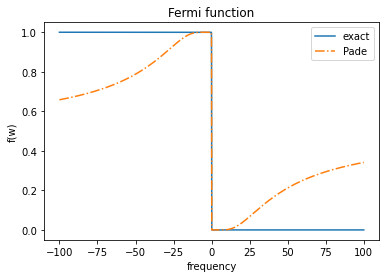

spectral_diss_rate:  (-2+0j)
spectral_eta  (0.46163475624596917-1.7107075774668585j)
pade_diss_rate 
 [ -0.06283185+0.j  -0.18849556+0.j  -0.31415927+0.j  -0.43982297+0.j
  -0.56548668+0.j  -0.69115038+0.j  -0.81681409+0.j  -0.9424778 +0.j
  -1.0681415 +0.j  -1.19380535+0.j  -1.31949279+0.j  -1.44619637+0.j
  -1.58443278+0.j  -1.76495399+0.j  -2.02608389+0.j  -2.42072165+0.j
  -3.05905273+0.j  -4.22944946+0.j  -6.99190012+0.j -20.89157037+0.j]
pade_eta 
 [0.-0.01848363j 0.-0.01863088j 0.-0.01893253j 0.-0.01940378j
 0.-0.02006985j 0.-0.02096963j 0.-0.02216192j 0.-0.02373645j
 0.-0.02583409j 0.-0.0286862j  0.-0.03272508j 0.-0.03973257j
 0.-0.06039882j 0.-0.14225723j 0.+1.77002799j 0.+0.15481247j
 0.+0.0909147j  0.+0.0697597j  0.+0.06048296j 0.+0.05673243j]


In [2]:
# the information of calculation paratemers
hbar = 0.658211928
omega_max = 100.0
omega_min = -100.0
omega_sample = 5000 + 1
omega = np.linspace(omega_min, omega_max, omega_sample)

# the information of fermi funcaiton
T = 0.02                 #eV
chemical_potential = 0.0 #ev

fermi = np.zeros(omega_sample)
for i in range(omega_sample):
    if ((omega[i] - chemical_potential) / (T)) <= 50 :
        fermi[i] = 1.0 / ( 1.0 + np.exp( (omega[i] - chemical_potential) / (T) ) )
    elif ((omega[i] - chemical_potential) / (T)) > 50 :
        fermi[i] = 1.0 / 10e+22

# the information of bath spectral funcation
# the Lorentz type J(w) = 0.5 * sys_bath_coupling * band_width**2 / ( (w - band_center)**2 + band_width**2)
sys_bath_coupling = 0.4  #eV, is equal to HEOM-QUICK
band_width = 2.0         #eV
band_center = 0.0        #eV
bath_spectral = np.zeros(omega_sample, dtype=complex)
bath_spectral = (0.5 * sys_bath_coupling * (band_width**2)) / ((omega + band_center)**2 + band_width**2)
spectral_diss_rate = (band_width - 1.j * band_center) / hbar
spectral_eta = 0.5 * sys_bath_coupling * band_width \
                / ( 1.0 + np.exp((1.j * spectral_diss_rate - chemical_potential) * hbar / T )) / hbar**2

#the Pade scheme
num_pade = 20
b = np.zeros(2 * num_pade)
mat_xi = np.zeros((2 * num_pade, 2 * num_pade))
mat_varsigma = np.zeros((2 * num_pade - 1, 2 * num_pade - 1))
tilde_eta = np.zeros(num_pade, dtype = complex)         # namely cpcoef in evaluatepara.f90 
pole = np.zeros(num_pade, dtype = complex)              # namely cppole in evaluatepara.f90
eta = np.zeros(num_pade, dtype = complex)               # namely cb in evaluatepara.f90
diss_rate = np.zeros(num_pade, dtype = complex)         # namely cgamma in evaluatepara.f90


for i in range(2 * num_pade):
    b[i] = 2 * (i) + 1

for i in range(2 * num_pade):
    for j in range(2 * num_pade):
        if (i == j-1 or i == j+1) :
            mat_xi[i,j] = 1.0 / np.sqrt(b[i] * b[j])

eigval_xi, eigvec_xi = np.linalg.eig(mat_xi) 
eigval_xi = np.sort(eigval_xi)
            
for i in range(2 * num_pade -1):
    for j in range(2 * num_pade -1):
        if (i == j-1 or i == j+1) :
            mat_varsigma[i,j] = 1.0 / np.sqrt(b[i+1] * b[j+1])

eigval_varsigma, eigvec_varsigma = np.linalg.eig(mat_varsigma)
eigval_varsigma = np.sort(eigval_varsigma)


for i in range(num_pade):
    pole[i] = (0. +2.j) / abs(eigval_xi[i])
    eigval_xi[i] = 4.0 / eigval_xi[i]**2
for i in range(num_pade-1):
    eigval_varsigma[i] = 4.0 / eigval_varsigma[i]**2

for i in range(num_pade):
    tilde_eta[i] = 0.5 * num_pade * (2 * num_pade + 1)
    for j in range(i):
        tilde_eta[i] = tilde_eta[i] * (eigval_varsigma[j] - eigval_xi[i]) / (eigval_xi[j] - eigval_xi[i])
    for j in range(i+1,num_pade):
        tilde_eta[i] = tilde_eta[i] * (eigval_varsigma[j-1] - eigval_xi[i]) / (eigval_xi[j] - eigval_xi[i])
    tilde_eta[i] = (-1. +0.j) * tilde_eta[i]

fermi_pade = np.zeros(omega_sample, dtype = np.complex128)
for i in range(omega_sample):
    fermi_pade[i] = 0.5
    for j in range(num_pade):
        fermi_pade[i] = fermi_pade[i] + tilde_eta[j] / (omega[i] / T + pole[j]) \
                                      + tilde_eta[j] / (omega[i] / T - pole[j])

        
plt.title("Fermi function") 
plt.xlabel("frequency") 
plt.ylabel("f(w)") 
plt.plot(omega, fermi, label = 'exact')
#plt.plot(omega, fermi_mats.real, label = 'Matsubara', linestyle = '--')
plt.plot(omega, fermi_pade.real, label = 'Pade', linestyle = '-.')
plt.legend(loc=1)
plt.show()

for i in range(num_pade):
    diss_rate[i] = -1.j * T * pole[i] / hbar
    eta[i] = 2.j * tilde_eta[i] * sys_bath_coupling * 0.5 * band_width**2 * T \
             / ( (pole[i] * T - band_center)**2 + band_width**2 ) / hbar**2

spectral_diss_rate = (band_width - 1.j * band_center) / hbar
spectral_eta = 0.5 * sys_bath_coupling * band_width \
                   * fermi_by_pade((1.j * spectral_diss_rate - chemical_potential) * hbar) / hbar**2

print('spectral_diss_rate: ', -1 * spectral_diss_rate * hbar)
print('spectral_eta ', spectral_eta)

print('pade_diss_rate \n', -1 * diss_rate * hbar)
print('pade_eta \n', eta)

eta_new = np.zeros(num_pade + 1, dtype = complex)               # namely cb in evaluatepara.f90
diss_rate_new = np.zeros(num_pade + 1, dtype = complex)         # namely cgamma in evaluatepara.f90
eta_new[0] = spectral_eta
diss_rate_new[0] = spectral_diss_rate
eta_new[1:] = eta[:]
diss_rate_new[1:] = diss_rate[:]

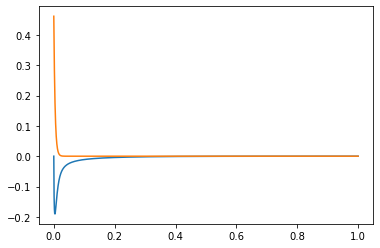

len(scale * t) 1001
scale * t
 [ 0.    0.08  0.16 ... 79.84 79.92 80.  ]
len(h) 1001
h
 [-6.78623824e-15 -1.33517365e-01 -1.74921795e-01 ... -9.05432943e-06
 -8.98544781e-06 -8.91709021e-06]
H[200][100]
 -0.0018893910216170816
error of decompose 5.94993507307484e-13
len of gamma 4
Qp[100][100]
 (5.050869096911205e-18-0.08248695216331463j)
para
 [-3.08233094e-04+0.j -3.10597044e-04+0.j -3.12979141e-04+0.j
 -3.15379524e-04+0.j -3.17798334e-04+0.j -3.20235712e-04+0.j
 -3.22691802e-04+0.j -3.25166747e-04+0.j -3.27660693e-04+0.j
 -3.30173786e-04+0.j -3.32706173e-04+0.j -3.35258003e-04+0.j
 -3.37829427e-04+0.j -3.40420593e-04+0.j -3.43031656e-04+0.j
 -3.45662767e-04+0.j -3.48314082e-04+0.j -3.50985755e-04+0.j
 -3.53677945e-04+0.j -3.56390809e-04+0.j -3.59124505e-04+0.j
 -3.61879196e-04+0.j -3.64655042e-04+0.j -3.67452207e-04+0.j
 -3.70270854e-04+0.j -3.73111151e-04+0.j -3.75973262e-04+0.j
 -3.78857357e-04+0.j -3.81763606e-04+0.j -3.84692178e-04+0.j
 -3.87643246e-04+0.j -3.90616984e-04+0.j -3

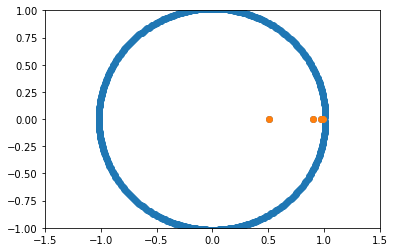

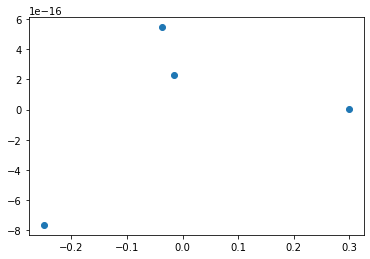

In [60]:
n = 500
scale = 80
n_gamma = 4

n_sample = n + 1
t = np.linspace(0, 1, 2 * n + 1)
res_t = np.zeros(len(t), dtype=complex)
expn_pade1 = diss_rate_new
etal_pade1 = eta_new
fit_t(scale * t, res_t, expn_pade1, etal_pade1)
plt.plot(t, np.imag(res_t))
plt.plot(t, np.real(res_t))
plt.show()
h = np.imag(res_t)

print("len(scale * t)",len(scale * t))
print("scale * t\n",scale * t)

print("len(h)",len(h))
print("h\n",h)

H = np.zeros((n_sample, n_sample))
for i in range(n_sample):
    H[i, :] = h[i:n_sample + i]

print("H[200][100]\n",H[200,100])
    
sing_vs, Q = linalg.eigh(H)
phase_mat = np.diag(
    [np.exp(-1j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
Qp = np.dot(Q, phase_mat)
sort_array = np.argsort(vs)[::-1]
vs = vs[sort_array]
Qp = (Qp[:, sort_array])
print(
    "error of decompose",
    np.sum(np.abs(H -
                  np.dot(np.dot(Qp, np.diag(vs)), (np.transpose(Qp))))))

print("len of gamma", n_gamma)

print("Qp[100][100]\n",Qp[100,100])
gamma = np.roots(Qp[:,n_gamma][::-1])
gamma_new = gamma[np.argsort(np.abs(gamma))[:n_gamma]]

print("para\n",Qp[:,n_gamma][::-1])
print("gamma_new\n",gamma_new)

t_new = 2*n*np.log(gamma_new)
plt.scatter(np.real(gamma),np.imag(gamma))
plt.scatter(np.real(gamma_new),np.imag(gamma_new))
plt.xlim(-1.5,1.5)
plt.ylim(-1,1)
plt.show()
gamma_m = np.zeros((n_sample*2-1, n_gamma), dtype=complex)
for i in range(n_gamma):
    for j in range(n_sample*2-1):
        gamma_m[j,i] = gamma_new[i]**j
omega_new = np.dot(LA.inv(np.dot(np.transpose(gamma_m), gamma_m)), np.dot(np.transpose(gamma_m), np.transpose(h)))
plt.scatter(np.real(omega_new),np.imag(omega_new))
plt.show()
